# Exponential Decay Fitting

Given a time series: 

$$
y[t_j]
$$

we model $y$ as a sum of decaying exponentials:

$$
y[t_j] = \sum_i A_i e^{\frac{t_j}{\tau_i}}
$$

We will solve a quadratic program to try to recover the $A_i$ given the $y[t_j]$

In [31]:
# Import the packages we'll need:

# JuMP is a modeling language, which lets us set up convex
# and non-convex optimizations efficiently
using JuMP

# Gurobi is a Julia package which provides bindings to the 
# gurobi solver
using Gurobi

# PyPlot is a wrapper around the Python Matplotlib package
# which lets us easily create plots with a syntax that is
# similar to Matlab's. 
using PyPlot

In [32]:
# Generate synthetic data y and true weights A
function synthetic_exponential(ts, taus, sparsity)
    A_true = zeros(num_taus)
    for i in 1:(num_taus * (sparsity))
        A_true[rand(1:num_taus)] = rand()
    end
    y = [sum(A_true[i] * exp(-ts[j] / taus[i]) for i in 1:num_taus) for j in 1:num_ts];
    y, A_true
end

synthetic_exponential (generic function with 2 methods)

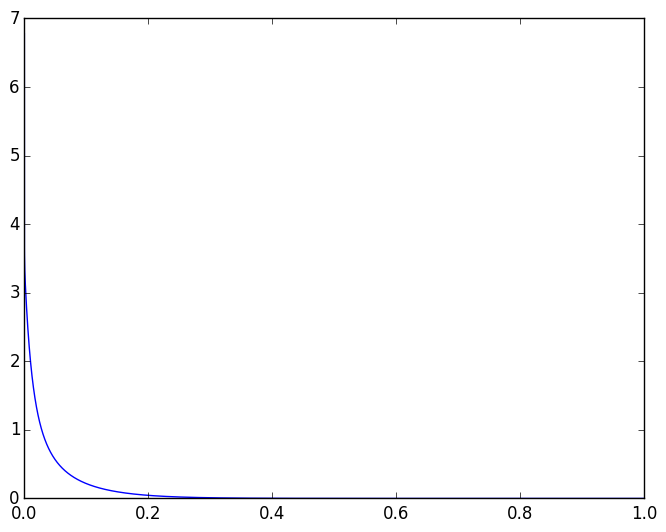

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32e9e9910>

In [33]:
num_ts = 10000
num_taus = 1000
sparsity = 0.01
ts = linspace(0, 1, num_ts)
taus = logspace(-7, 0, num_taus)
y, A_true = synthetic_exponential(ts, taus, sparsity)

plot(ts, y)

In [34]:
# This is a helper function to compute the 1-norm of a vector
# of decision variables. It does so by introducing a new slack
# variable. 
function norm1(model::Model, variable::AbstractArray{Variable})
    @variable model slack[1:length(variable)]
    @constraint model slack .>= variable
    @constraint model slack .>= -variable
    sum(slack)
end

norm1 (generic function with 1 method)

In [48]:
# This is the function which actually performs the optimization
# and returns the estimated weights.
function estimate_weights(ts, taus, regularization_type, regularization_weight)
    num_taus = length(taus)
    num_ts = length(ts)
    
    # Create a new model, and tell it we'll use Gurobi as the solver
    model = Model(solver=GurobiSolver())
    
    # Declare variables
    @variable model A[1:num_taus]
    # yhat is a new variable which we will use in our objective function.
    # we'll constrain that yhat[j] == sum(A[i] * exp(-ts[j] / tau[i])) later
    @variable model yhat[1:num_ts]
    
    # Add an appropriate objective function
    if regularization_type == :norm2
        @objective model Min sum{(y[i] - yhat[i])^2 + regularization_weight * A[i]^2, i=1:num_taus}
    elseif regularization_type == :norm1
        @objective model Min sum{(y[i] - yhat[i])^2, i=1:num_taus} + regularization_weight * norm1(model, A)
    end
    
    # Constrain yhat to take on the correct value given the A[i]s
    @constraint model [j=1:num_ts] yhat[j] == sum{A[i] * exp(-ts[j] / taus[i]), i=1:num_taus}
    
    # Non-negativity. The . in .>= 0 is just like matlab (it means 
    # to operate elementwise on the vector A). 
    @constraint model A .>= 0
    
    # Actually run the solver
    solve(model)
    
    # Retrieve the value from each entry of A and return it
    getvalue.(A)
end

estimate_weights (generic function with 1 method)

# Solving the problem

First, we'll solve the estimation problem with a 2-norm regularization:

In [40]:
# @time is a macro which, like tic() and toc(), lets us
# measure how much time a given line took. 
# 
# I'm using it here to estimate the overhead involved in
# setting up the problem, as opposed to the time spent in
# the solver. Gurobi will print out a line like:
# 
# Barrier solved model in 18 iterations and 1.19 seconds
# 
# which tells us how long we spent inside gurobi, and the @time
# macro prints out:
# 
# 2.986443 seconds (170.93 k allocations: 686.448 MB, 20.68% gc time)
# 
# which is the total time. So the overhead is the total time
# minus the gurobi time (about 1.8 seconds in this case). 
@time A = estimate_weights(ts, taus, :norm2, 3e-4);

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 11000 rows, 11000 columns and 2742861 nonzeros
Model has 2000 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [4e-01, 1e+01]
  QObjective range [6e-04, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 10000 rows and 9000 columns
Presolve time: 0.27s
Presolved: 1000 rows, 2000 columns, 417223 nonzeros
Presolved model has 2000 quadratic objective terms
Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.995e+05
 Factor NZ  : 5.005e+05 (roughly 5 MBytes of memory)
 Factor Ops : 3.338e+08 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.56338494e+08 -5.57199998e+08  1.00e+06 0.00e+00  9.99e+05     0s
   1   6.72772589e+07 -6.77260735e+07  1.11e+03 0.00e+

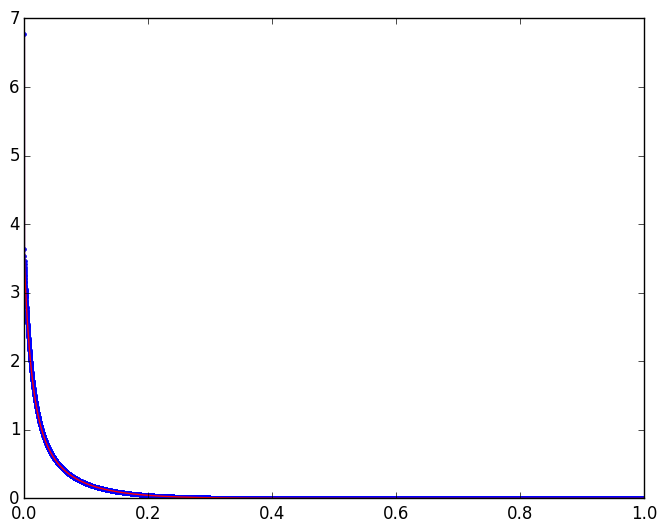

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32a7f2690>
 PyObject <matplotlib.lines.Line2D object at 0x32a7f2910>

In [41]:
# For sanity, let's make sure the estimated weights produce a good
# fit for the data
yhat = [sum(A[i] * exp(-ts[j] / taus[i]) for i in 1:num_taus) for j in 1:num_ts]
plot(ts, yhat, "b.-", ts, y, "r-")

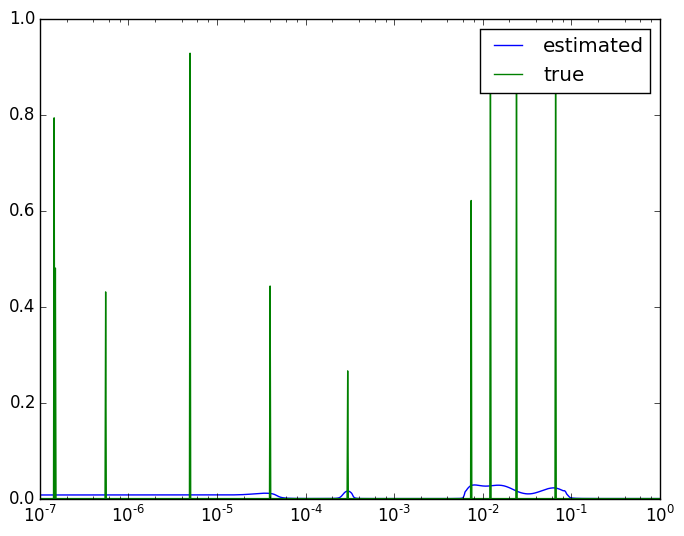

PyObject <matplotlib.legend.Legend object at 0x32db9fed0>

In [43]:
# And let's compare the estimated and true weights
semilogx(taus, A, taus, A_true)
legend(["estimated", "true"])

# Trying a 1-norm

Now let's redo the computation, but with a 1-norm penalty on the weights instead of a 2-norm:

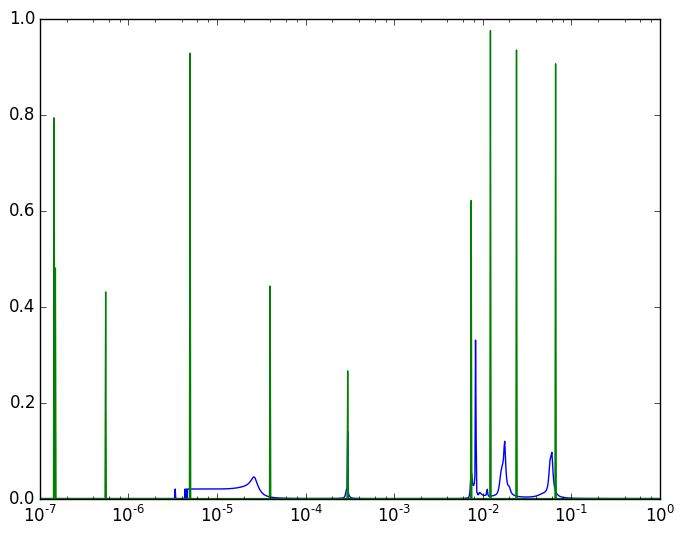

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 13000 rows, 12000 columns and 2746861 nonzeros
Model has 1000 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [1e-01, 1e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 12000 rows and 10234 columns
Presolve time: 0.34s
Presolved: 1000 rows, 1766 columns, 416972 nonzeros
Presolved model has 1000 quadratic objective terms
Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.995e+05
 Factor NZ  : 5.005e+05 (roughly 5 MBytes of memory)
 Factor Ops : 3.338e+08 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.49215094e+08 -2.49999998e+08  7.66e+05 0.00e+00  9.99e+05     0s
   1   6.78653052e+07 -6.83183643e+07  2.57e+03 3.86e

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x34d95a290>
 PyObject <matplotlib.lines.Line2D object at 0x32efde690>

In [54]:
A = estimate_weights(ts, taus, :norm1, 1e-1)
semilogx(taus, A, taus, A_true)